In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps
import PIL
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dataset import defectDataset_convolution
import random
import math
import seaborn
from  matplotlib import pyplot
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.nn as nn
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [10]:
df_yolo = pd.read_csv('/home/rliu/github/defect_classifier/yolo2_dm/results/test_yolo.csv', sep=' ')

In [11]:
step_size = 2
window_size = 45


In [12]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask = mask.astype(int)
    return mask

mask = create_circular_mask(200,200)

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 10 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2nd Full-Connected Layer: 500 (hidden node) -> 5 (output class)
#         self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
#         self.fc3 = nn.Linear(hidden_size, num_classes) # 3rd Full-Connected Layer: 500 (hidden node) -> 5 (output class)
    
    def forward(self, x):                              # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
        return out

In [14]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(200, scale=(1, 1), ratio=(1, 1)),
#         transforms.RandomRotation((-90,90)),
#         torchvision.transforms.RandomVerticalFlip(p=0.5),
#         torchvision.transforms.RandomHorizontalFlip(p=0.5),
#         torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3019],
                             std=[0.1909])
    ])

In [15]:
classes = ["pos","neg","pos_o","nuc","non"]
num_of_classes = len(classes)
model_uniform = torch.load('/home/rliu/defect_classifier/models/python/ml/res34_600epo_uniform_01-07-18.model')
model_uniform.eval()
model_hard = torch.load('/home/rliu/defect_classifier/models/python/ml/res34_600epo_hard_01-07-18.model')
model_hard.eval()
model_FNN = torch.load('/home/rliu/defect_classifier/models/python/ml/2x100_28epo_yolo_01-13-18.model')
model_FNN.eval()

/home/rliu/.local/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Net(
  (fc1): Linear(in_features=10, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [16]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU in use")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if use_gpu:
    model_uniform = torch.nn.DataParallel(model_uniform)
    model_uniform.to(device)
    model_hard = torch.nn.DataParallel(model_hard)
    model_hard.to(device)
    model_FNN = torch.nn.DataParallel(model_FNN)
    model_FNN.to(device)

GPU in use


In [17]:
model_uniform.train(False)
model_hard.train(False)
model_FNN.train(False)

DataParallel(
  (module): Net(
    (fc1): Linear(in_features=10, out_features=100, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=100, out_features=5, bias=True)
  )
)

In [18]:
def sliding_window(image, stepSize, windowSize, xmin, xmax, ymin, ymax):
    print(xmin,xmax,ymin,ymax)
    for x in range(xmin, xmax, stepSize):
        for y in range(ymin, ymax, stepSize):
            yield (x, y, image.crop(box=(x - windowSize/2,y - windowSize/2, x + windowSize/2, y + windowSize/2)))

In [21]:
columns = ['image_index','class', 'x', 'y']
df_results = pd.DataFrame(index=np.arange(0), columns=columns)
for i in np.arange(6765,6766):
    img = Image.open('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/%06.0f.jpg' % i).convert('L')
    df_bbox = df_yolo[df_yolo['image_index']==i]
    img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
    for index, row in df_bbox.iterrows():
        width, height = img.size
        x1, y1, x2, y2 = row.x1, row.y1, row.x2, row.y2
        x1, y1, x2, y2 = min(max(x1,0),1), min(max(y1,0),1), min(max(x2,0),1), min(max(y2,0),1)
        xmin, ymin, xmax, ymax = int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)
        xmin, ymin, xmax, ymax = min(max(xmin,0),300), min(max(ymin,0),300), min(max(xmax,0),300), min(max(ymax,0),300)
        confidence_pos, confidence_neg, confidence_pos_o, confidence_nuc, confidence_non = torch.zeros(img.size[0],img.size[1]), torch.zeros(img.size[0],img.size[1]), torch.zeros(img.size[0],img.size[1]), torch.zeros(img.size[0],img.size[1]), torch.zeros(img.size[0],img.size[1])
        print(index)
        for (x,y, window) in sliding_window(image=img, stepSize=step_size, windowSize=window_size, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax):
            img_resized = torchvision.transforms.functional.resize(window, (200,200), interpolation=2)
            img_masked = img_resized * mask
            img_masked = Image.fromarray(img_masked.astype('uint8'), 'L')
        #     plt.imshow(img_masked)
            inputs = data_transform(img_masked)
            inputs = inputs.unsqueeze(0)
            with torch.no_grad():
                outputs_uniform = model_uniform(inputs)
                outputs_hard = model_hard(inputs)
                outputs_in = torch.cat((outputs_uniform, outputs_hard), dim=1)
                outputs_out = model_FNN(outputs_in)
        #     print(outputs_out)
            confidences = F.softmax(outputs_out, dim=1)
        #     print(confidences)
            confidence_pos[x,y]=confidences[0,0]
            confidence_neg[x,y]=confidences[0,1]
            confidence_pos_o[x,y]=confidences[0,2]
            confidence_nuc[x,y]=confidences[0,3]
            confidence_non[x,y]=confidences[0,4]
        w = len(range(xmin, xmax, step_size))
        h = len(range(ymin, ymax, step_size))
        df_img = findLocalMax(confidence_pos, confidence_neg, confidence_pos_o, confidence_nuc, confidence_non, w, h)
        df_img['image_index'] = i
        df_img['x'] = df_img['x']*(x2-x1) + x1
        df_img['y'] = df_img['y']*(y2-y1) + y1
        df_results = df_results.append(df_img)
        print(df_results)

3653
232 291 143 201
  image_index class         x        y
0        6765     4  0.776663  0.47835
1        6765     4  0.776663  0.47835
3654
99 146 57 105
  image_index class         x         y
0        6765     4  0.776663   0.47835
1        6765     4  0.776663   0.47835
0        6765     4  0.331887  0.191499
1        6765     4  0.331887  0.191499
3655
190 239 238 285
  image_index class         x         y
0        6765     4  0.776663   0.47835
1        6765     4  0.776663   0.47835
0        6765     4  0.331887  0.191499
1        6765     4  0.331887  0.191499
0        6765     4  0.633762  0.795893
3656
1 62 160 229
  image_index class           x         y
0        6765     4    0.776663   0.47835
1        6765     4    0.776663   0.47835
0        6765     4    0.331887  0.191499
1        6765     4    0.331887  0.191499
0        6765     4    0.633762  0.795893
0        6765     1  0.00345546  0.536404
1        6765     1  0.00345546  0.536404
0        6765     4  0.00345

KeyboardInterrupt: 

In [37]:
df_results

,image_index,class,x,y
0,6501,0,0.468543,0.382798
1,6501,0,0.408995,0.448501
0,6501,0,0.270704,0.609587
1,6501,0,0.224636,0.629796
0,6501,0,0.459526,0.782313
0,6501,0,0.285768,0.904372
0,6501,0,0.332033,0.910735
1,6501,0,0.272549,0.808925
2,6501,0,0.226284,0.898009
3,6501,0,0.199847,0.853467


In [1]:
img = Image.open('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/006765.jpg').convert('L')
size = img.size
confidence_pos = torch.zeros(img.size[0],img.size[1])
confidence_neg = torch.zeros(img.size[0],img.size[1])
confidence_pos_o = torch.zeros(img.size[0],img.size[1])
confidence_nuc = torch.zeros(img.size[0],img.size[1])
confidence_non = torch.zeros(img.size[0],img.size[1])
img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
width, height = img.size
# img = ImageOps.expand(img, border=22, fill=0)
for (x,y, window) in sliding_window(image=img, stepSize=2, windowSize=45, xmin=0, xmax=1, ymin=0, ymax=1):
    print(y)
    img_resized = torchvision.transforms.functional.resize(window, (200,200), interpolation=2)
    img_masked = img_resized * mask
    img_masked = Image.fromarray(img_masked.astype('uint8'), 'L')
#     plt.imshow(img_masked)
    img = data_transform(img_masked)
    img = img.unsqueeze(0)
    with torch.no_grad():
        outputs_uniform = model_uniform(img)
        outputs_hard = model_hard(img)
        outputs_in = torch.cat((outputs_uniform, outputs_hard), dim=1)
        outputs_out = model_FNN(outputs_in)
    confidences = F.softmax(outputs_out, dim=1)
    
    confidence_pos[x,y]=confidences[0,0]
    
    confidence_neg[x,y]=confidences[0,1]
    confidence_pos_o[x,y]=confidences[0,2]
    confidence_nuc[x,y]=confidences[0,3]
    confidence_non[x,y]=confidences[0,4]

NameError: name 'Image' is not defined

In [71]:
mm_pos = confidence_pos
mm_neg = confidence_neg
mm_pos_o = confidence_pos_o
mm_nuc = confidence_nuc
mm_non = confidence_non

In [20]:
def findLocalMax(confidence_pos, confidence_neg, confidence_pos_o, confidence_nuc, confidence_non, width, height):
    columns = ['image_index','class', 'x', 'y']
    df_img = pd.DataFrame(index=np.arange(0), columns=columns)
    index = confidence_pos.nonzero()
    npmm = confidence_pos.numpy()
    npin = index.numpy()
    a = np.array([])
    for x,y in npin:
        a=np.append(a,npmm[x,y])
    im = a.reshape([width, height])
    coordinates = peak_local_max(im, min_distance=5, threshold_abs=0.5)
    coordinates[:,0] = coordinates[:,0]/width
    coordinates[:,1] = coordinates[:,1]/height
    df = pd.DataFrame(index=np.arange(coordinates.shape[0]), columns=columns)
    df['class'] = 0
    df['image_index'] = 0
    df['x'] = coordinates[:,0]
    df['y'] = coordinates[:,1]
    df_img = df_img.append(df)
    
    index = confidence_neg.nonzero()
    npmm = confidence_neg.numpy()
    npin = index.numpy()
    a = np.array([])
    for x,y in npin:
        a=np.append(a,npmm[x,y])
    im = a.reshape([width, height])
    coordinates = peak_local_max(im, min_distance=5, threshold_abs=0.5)
    coordinates[:,0] = coordinates[:,0]/width
    coordinates[:,1] = coordinates[:,1]/height
    df = pd.DataFrame(index=np.arange(coordinates.shape[0]), columns=columns)
    df['class'] = 1
    df['image_index'] = 1
    df['x'] = coordinates[:,0]
    df['y'] = coordinates[:,1]
    df_img = df_img.append(df)

    index = confidence_pos_o.nonzero()
    npmm = confidence_pos_o.numpy()
    npin = index.numpy()
    a = np.array([])
    for x,y in npin:
        a=np.append(a,npmm[x,y])
    im = a.reshape([width, height])
    coordinates = peak_local_max(im, min_distance=5, threshold_abs=0.5)
    coordinates[:,0] = coordinates[:,0]/width
    coordinates[:,1] = coordinates[:,1]/height
    df = pd.DataFrame(index=np.arange(coordinates.shape[0]), columns=columns)
    df['class'] = 2
    df['image_index'] = 1
    df['x'] = coordinates[:,0]
    df['y'] = coordinates[:,1]
    df_img = df_img.append(df)
    
    index = confidence_nuc.nonzero()
    npmm = confidence_nuc.numpy()
    npin = index.numpy()
    a = np.array([])
    for x,y in npin:
        a=np.append(a,npmm[x,y])
    im = a.reshape([width, height])
    coordinates[:,0] = coordinates[:,0]/width
    coordinates[:,1] = coordinates[:,1]/height
    df = pd.DataFrame(index=np.arange(coordinates.shape[0]), columns=columns)
    df['class'] = 3
    df['image_index'] = 1
    df['x'] = coordinates[:,0]
    df['y'] = coordinates[:,1]
    df_img = df_img.append(df)
    
    index = confidence_non.nonzero()
    npmm = confidence_non.numpy()
    npin = index.numpy()
    a = np.array([])
    for x,y in npin:
        a=np.append(a,npmm[x,y])
    im = a.reshape([width, height])
    coordinates = peak_local_max(im, min_distance=5, threshold_abs=0.5)
    coordinates[:,0] = coordinates[:,0]/width
    coordinates[:,1] = coordinates[:,1]/height
    df = pd.DataFrame(index=np.arange(coordinates.shape[0]), columns=columns)
    df['class'] = 4
    df['image_index'] = 1
    df['x'] = coordinates[:,0]
    df['y'] = coordinates[:,1]
    df_img = df_img.append(df)
    return df_img

In [72]:
index=mm_pos.nonzero()
mm_pos[index]


tensor([[[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000],
         [0.0003, 0.0000, 0.0003,  ..., 0.0000, 0.0000, 0.0000]]])

In [156]:
npmm = mm_pos.numpy()
npin = index.numpy()
a = np.array([])
for y,x in npin:
    a=np.append(a,npmm[x,y])
    

In [150]:
math.sqrt(22500)

150.0

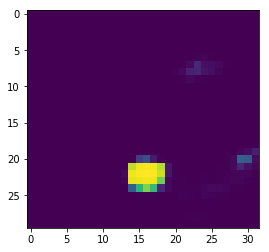

In [39]:
im = arr_pos
# plt.imshow(im)
im = im[73:103,54:86]
plt.imshow(im)

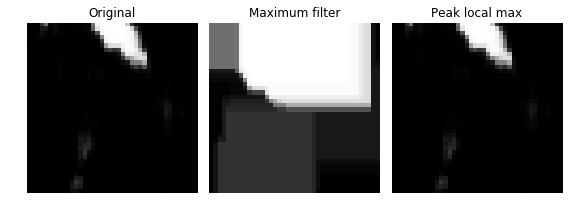

In [201]:
# plt.imshow(a.reshape([150,150]))
# im = a.reshape([150,150])
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=10, threshold_abs=0.5)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [228]:
coordinates

array([], shape=(0, 2), dtype=int64)

array([0.46854329, 0.40899459, 0.27070419, 0.22463573, 0.45952581,
       0.28576758, 0.33203275, 0.27254896, 0.22628378, 0.19984654,
       0.55458699, 0.5077462 , 0.07594147, 0.13456167, 0.57407178,
       0.53490563, 0.46653055, 0.38739665])

In [19]:
img = Image.open('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/006501.jpg').convert('L')

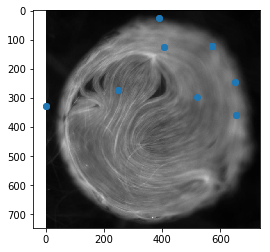

In [21]:
plt.imshow(img)

x = df_results['x'].values*img.width
y = df_results['y'].values*img.height
plt.scatter(y,x)

In [175]:
coordinates

array([[0.62666667, 0.36      ],
       [0.58666667, 0.6       ],
       [0.57333333, 0.84      ],
       [0.49333333, 0.20666667],
       [0.27333333, 0.28666667],
       [0.20666667, 0.55333333]])

In [2]:
arr_pos = np.load('/home/rliu/defect_classifier/convolution_test/pos/%06.0f.npy' % 6765)

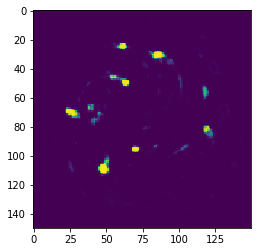

In [3]:
plt.imshow(arr_pos)

In [5]:
fig = plt.figure(figsize=(5, 5))

<Figure size 360x360 with 0 Axes>

In [10]:
# ax2 = fig.add_subplot(2,2,1) 
ax2.imshow(arr_pos, interpolation='nearest')
# ax2.set_title('5 X 5')
fig.savefig('/home/rliu/example.png', dpi = 1000) 

In [33]:
arr_pos

array([[0.00024666, 0.00025006, 0.00025737, ..., 0.00027383, 0.00026928,
        0.00026378],
       [0.00024956, 0.00025482, 0.00026338, ..., 0.00027921, 0.0002733 ,
        0.00026637],
       [0.00025228, 0.00026022, 0.00027003, ..., 0.00028753, 0.00028017,
        0.00027235],
       ...,
       [0.00025946, 0.00027043, 0.00028204, ..., 0.00027204, 0.00026991,
        0.00026544],
       [0.0002551 , 0.00026303, 0.00027189, ..., 0.00027178, 0.00027006,
        0.00026603],
       [0.0002495 , 0.0002542 , 0.00026186, ..., 0.00027121, 0.00026913,
        0.00026527]])